# Bank Loan Qualifier Predictor

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder

# 1. DATA COLLECTION

In [2]:
df = pd.read_csv("data/bankloan.csv")
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0.0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1.0,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0.0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0.0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0.0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


# 2. DATA CLEANING

In [3]:
df.shape

(614, 13)

In [4]:
df.drop(["Loan_ID"], axis = 1, inplace=True)
df.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0.0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,Male,Yes,1.0,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,Male,Yes,0.0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,Male,Yes,0.0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,Male,No,0.0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [5]:
df.dtypes

Gender                object
Married               object
Dependents           float64
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
dtype: object

In [6]:
df.dtypes

Gender                object
Married               object
Dependents           float64
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
dtype: object

In [7]:
df.describe()

,Dependents,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,599.000000,614.000000,614.000000,592.000000,600.00000,564.000000
mean,0.762938,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,1.015216,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,0.000000,150.000000,0.000000,9.000000,12.00000,0.000000
25%,0.000000,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,0.000000,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,2.000000,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,3.000000,81000.000000,41667.000000,700.000000,480.00000,1.000000


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 12 columns):
Gender               601 non-null object
Married              611 non-null object
Dependents           599 non-null float64
Education            614 non-null object
Self_Employed        582 non-null object
ApplicantIncome      614 non-null int64
CoapplicantIncome    614 non-null float64
LoanAmount           592 non-null float64
Loan_Amount_Term     600 non-null float64
Credit_History       564 non-null float64
Property_Area        614 non-null object
Loan_Status          614 non-null object
dtypes: float64(5), int64(1), object(6)
memory usage: 57.7+ KB


In [9]:
df.isna().sum()

Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [10]:
df.dtypes

Gender                object
Married               object
Dependents           float64
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
dtype: object

In [11]:
# Filling NANs in categorical variables
df["Gender"].fillna("Female", inplace = True)  
df["Married"].fillna("No", inplace=True)
df["Self_Employed"].fillna("Yes", inplace=True)

In [12]:
# Filling NaNs in Numerical variables
df["Dependents"].fillna(df.Dependents.median(), inplace=True)
df["LoanAmount"].fillna(df.LoanAmount.median(), inplace=True)
df["Loan_Amount_Term"].fillna(df.Loan_Amount_Term.median(), inplace=True)
df["Credit_History"].fillna(df.Credit_History.median(), inplace=True)

In [13]:
df.isna().sum()

Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

In [14]:
df["Dependents"] = df["Dependents"].astype(int)
df["Credit_History"] = df["Credit_History"].astype(int)

In [15]:
df.dtypes

Gender                object
Married               object
Dependents             int32
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History         int32
Property_Area         object
Loan_Status           object
dtype: object

In [16]:
df.shape

(614, 12)

# 3. EXPLORATORY DATA ANALYSIS

# 3.1. NUMERICAL FEATURES

In [17]:
df_num = df[["ApplicantIncome", "CoapplicantIncome", "LoanAmount", "Loan_Amount_Term"]]

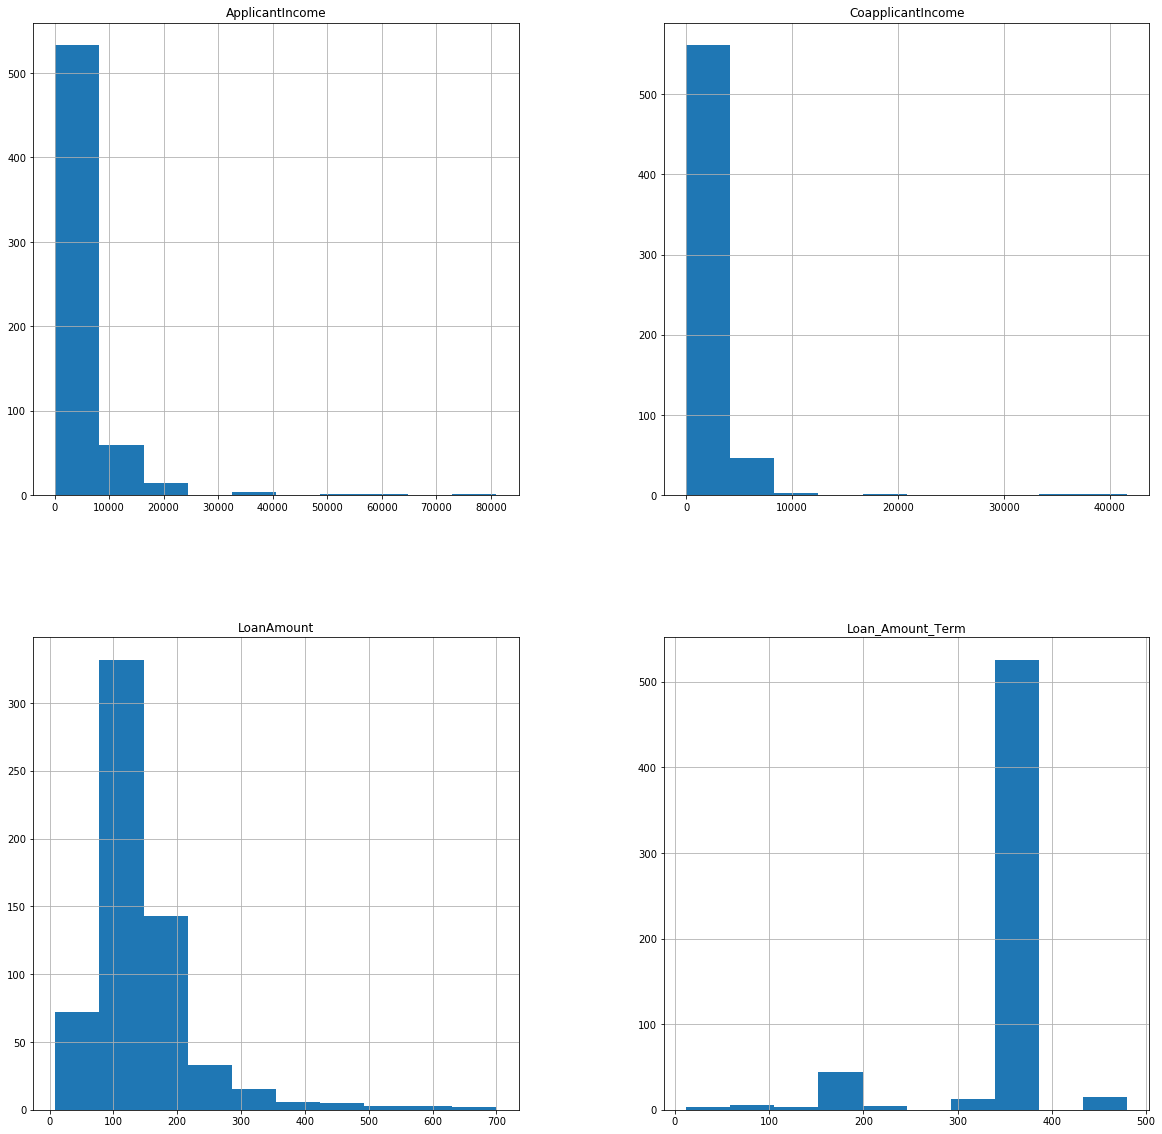

In [18]:
df_num.hist(figsize=(20,20));

### 3.1.1. Loan Amount

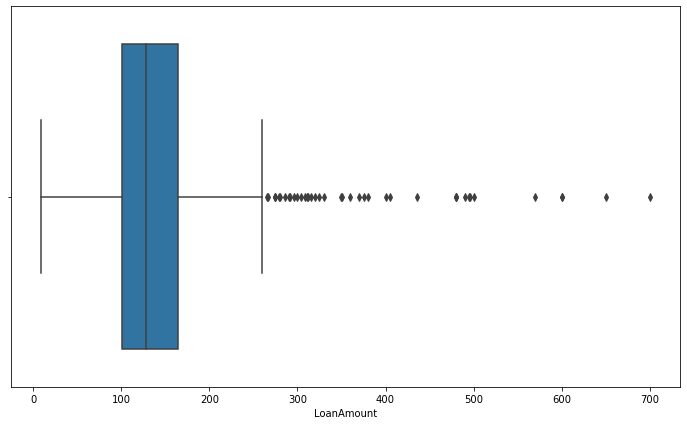

In [19]:
plt.figure(figsize=(12,7))

sns.boxplot(df["LoanAmount"])

plt.show()

**OBSERVATION**:
- The data is skewed to the right.
- Q1 is 100.
- Maximum value is 700.

### 3.1.2. Applicant Income

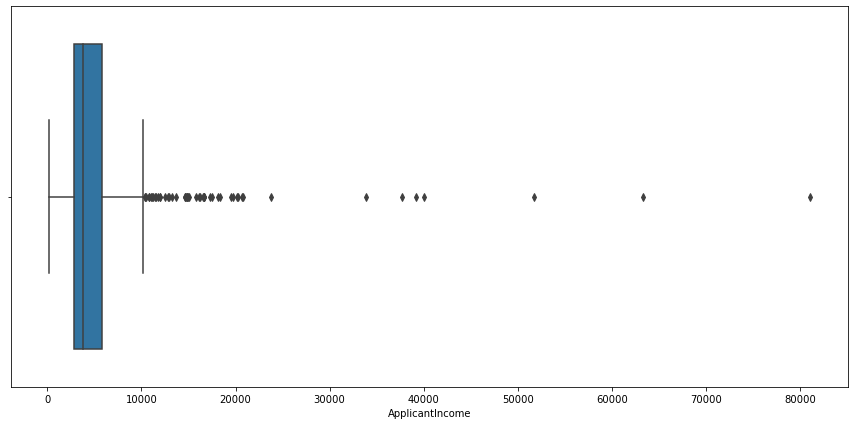

In [20]:
plt.figure(figsize=(15,7))

sns.boxplot(df["ApplicantIncome"])

plt.show()

**OBSERVATION**:
- The data is skewed to the right.
-  Minimum value is 0.

### 3.1.3. Applicant Income vs Loan Amount

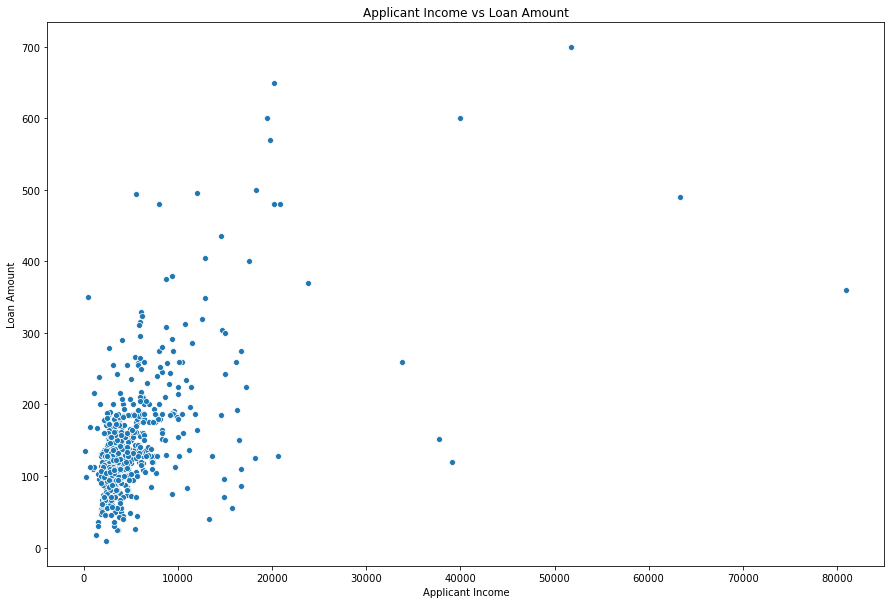

In [21]:
plt.figure(figsize=(15,10))
sns.scatterplot(x="ApplicantIncome", y="LoanAmount", data=df)
plt.xlabel("Applicant Income")
plt.ylabel("Loan Amount")
plt.title("Applicant Income vs Loan Amount")
plt.show()

### 3.1.4. Correlation

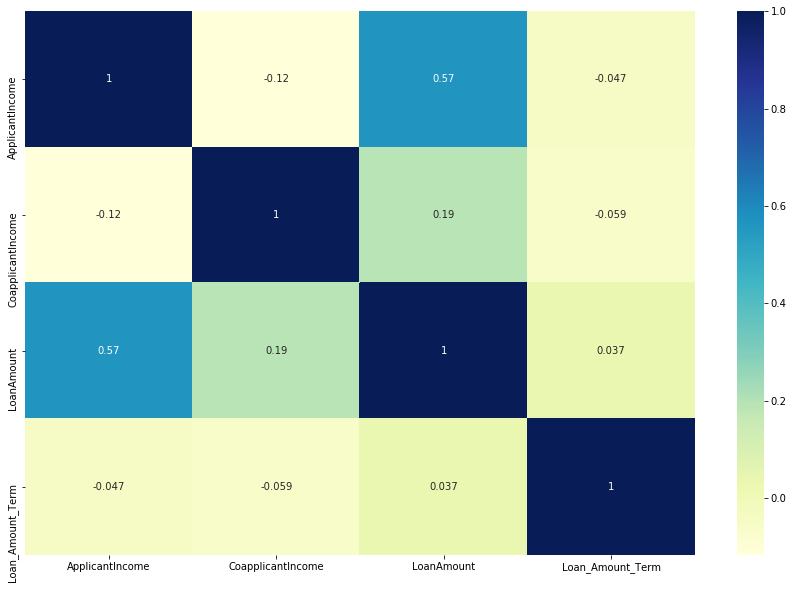

In [22]:
plt.figure(figsize=(15,10))

sns.heatmap(df_num.corr(), annot=True, cmap="YlGnBu");

**OBSERVATION**:
- **Applicant Income** and **Loan Amount** have a positive correlation.

## 3.2. CATEGORICAL FEATURES

### 3.2.1. GENDER

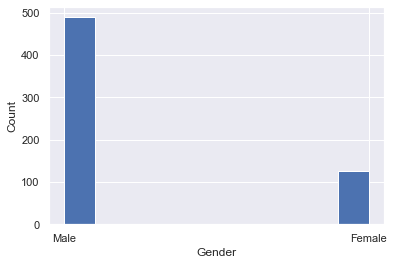

In [23]:
sns.set()
plt.hist(df.Gender)
plt.xlabel("Gender")
plt.ylabel("Count")
plt.show()

### 3.2.2. MARRIED

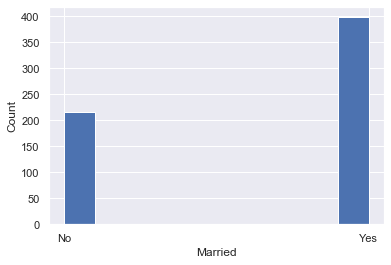

In [24]:
sns.set()
plt.hist(df.Married)
plt.xlabel("Married")
plt.ylabel("Count")
plt.show()

### 3.2.3. EDUCATION

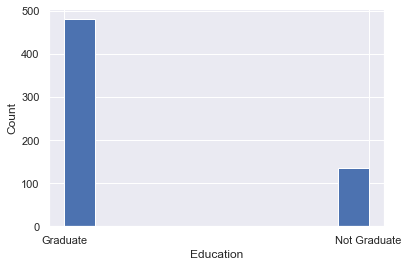

In [25]:
sns.set()
plt.hist(df.Education)
plt.xlabel("Education")
plt.ylabel("Count")
plt.show()

### 3.2.4. SELF-EMPLOYED

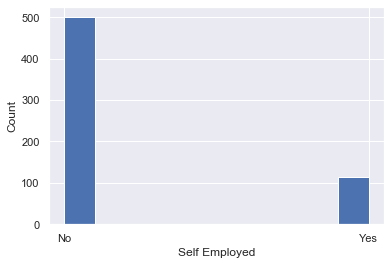

In [26]:
sns.set()
plt.hist(df.Self_Employed)
plt.xlabel("Self Employed")
plt.ylabel("Count")
plt.show()

### 3.2.5. PROPERY AREA

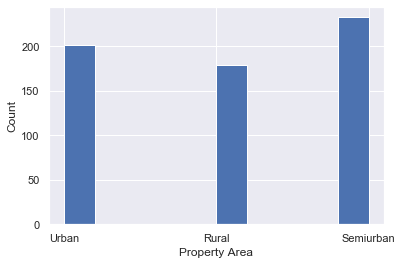

In [27]:
sns.set()
plt.hist(df.Property_Area)
plt.xlabel("Property Area")
plt.ylabel("Count")
plt.show()

### 3.2.6 LOAN STATUS

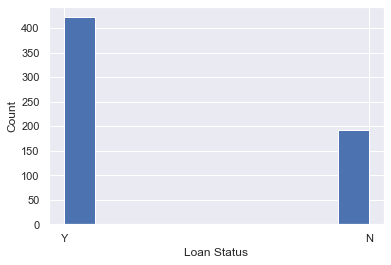

In [28]:
sns.set()
plt.hist(df.Loan_Status)
plt.xlabel("Loan Status")
plt.ylabel("Count")
plt.show()

### 3.2.7. DEPENDENTS

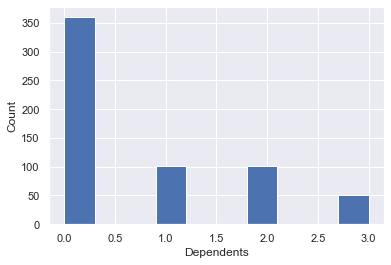

In [29]:
sns.set()
plt.hist(df.Dependents)
plt.xlabel("Dependents")
plt.ylabel("Count")
plt.show()

### 3.2.8. CREDIT HISTORY

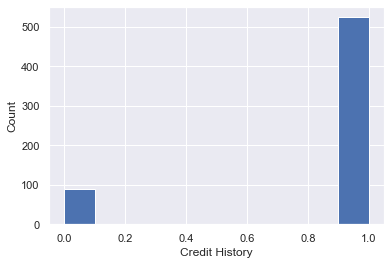

In [30]:
sns.set()
plt.hist(df.Credit_History)
plt.xlabel("Credit History")
plt.ylabel("Count")
plt.show()

In [31]:
# Convert Categorical Features to Numeric
le = LabelEncoder()

# Apply le on categorical feature columns
df[['Gender', 'Married', 'Education', 'Self_Employed', 'Property_Area', 'Loan_Status']] = df[['Gender', 'Married', 'Education', 'Self_Employed', 'Property_Area', 'Loan_Status']].apply(lambda col: le.fit_transform(col))